# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Import all the necessary Library

In [1]:
import os
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from Utility import *

%matplotlib inline

## Distortion Correction

### Compute the camera calibration using chessboard images

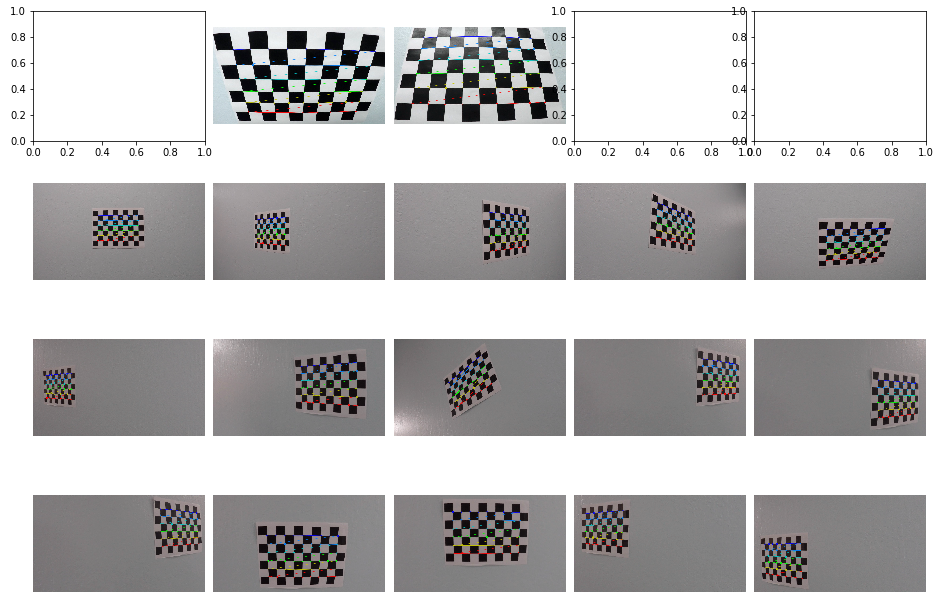

In [2]:
row = 6
column = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros( (row * column, 3), np.float32)
objp[:, :2] = np.mgrid[0:column, 0:row].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(4,5, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.05)
axs = axs.ravel()

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(grayImg, (column,row), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        
        corners2 = cv2.cornerSubPix(grayImg, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
    
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (column, row), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)


### Test Undistortion with Chessboard

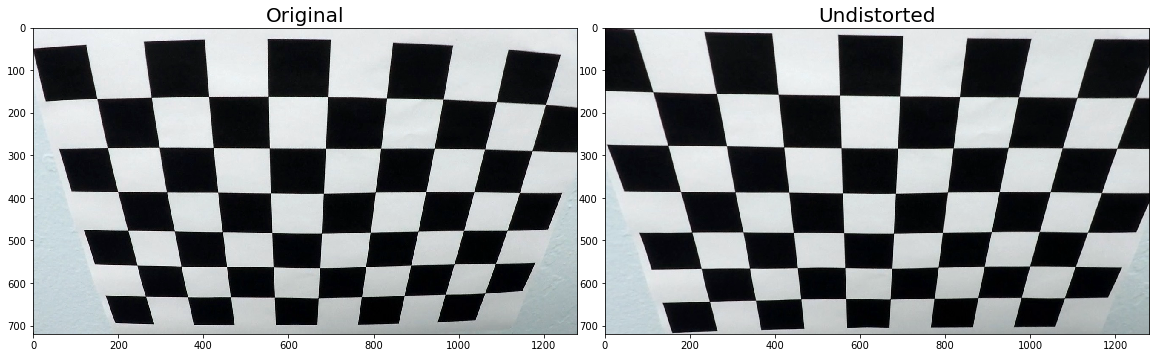

In [3]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration02.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = undistort(img, dist, mtx)

displayResult(img, dst, "Original", "Undistorted", False)


### Test undistortion with Street Image

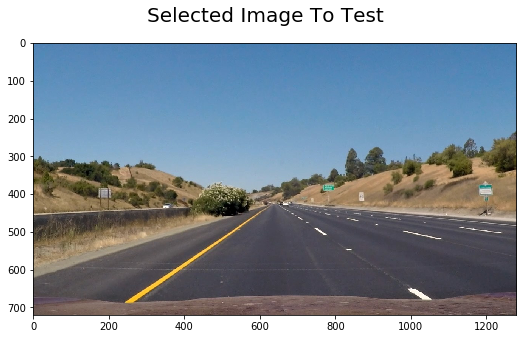

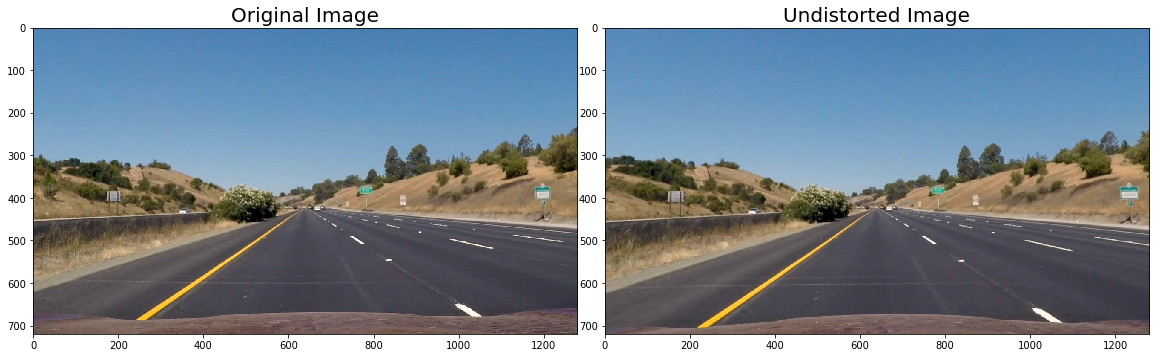

In [4]:
# Choose a test image 
aImg = cv2.imread('./test_images/straight_lines1.jpg')
aImg = cv2.cvtColor(aImg, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.suptitle("Selected Image To Test", fontsize=20)
plt.imshow(aImg)

aImg_Undistort = undistort(aImg, dist, mtx)

displayResult(aImg, aImg_Undistort , "Original Image", "Undistorted Image", False )

### Perspective Transform

* Perspective
    * Objects appear Smaller the farther away they are from a viewpoint parallel lines seem to converge to a point
    * Perspective to give the right impression of an object's size, depth, and position when viewed from a particular point.
    * Lane looks smaller the farther aways it gets from the camera.
    
* Characterize with Mathematical Perspective
    * in real world coordinates x, y, and z, the greater the magnitude of an objects z coordinate, or distance from the camera, the smaller it will appear in a 2D image
    
* A perspective transform 
    * warps the image and effectively drags points towards or pushes them away from the camera to change the apparent perspective.
    * a lane are easier to perform on a bird's eye view of an image
    * the process of applying a perspective transform will be kind of similar to how we applied undistortion
    
   
* define source and destination points for transform
    * src = np.float32([(575,464), (707,464), (258,682), (1049,682)])	
    * dst = np.float32([(200,0), (width-200,0), (200,hight), (width-200,hight)])

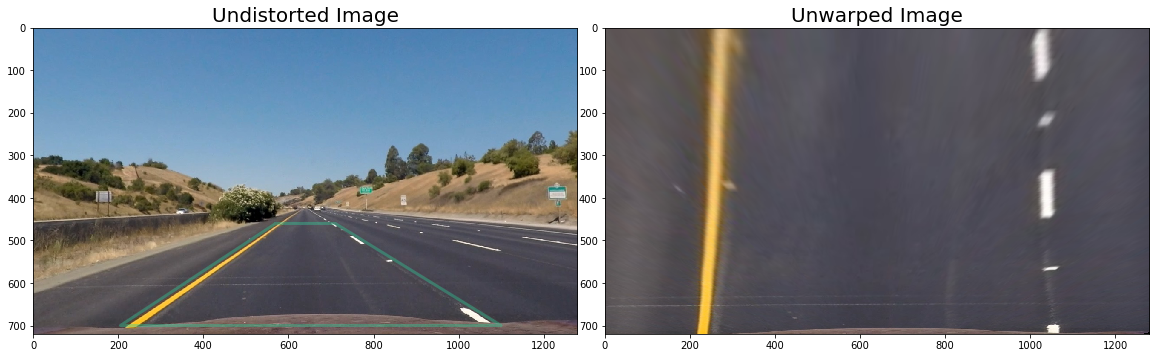

In [5]:
aImg_unwarp, M, Minv = unwarp(aImg_Undistort)

displayResult(aImg_Undistort, aImg_unwarp, 'Undistorted Image', 'Unwarped Image' , True  )

## Canny edge detection algorithm

### Applying Sobel Operator

* The Sobel operator is at the heart of the Canny edge detection algorithm
* Applying the Sobel operator to an image is a way of taking the derivative of the image in the xx or yy direction.
    * Sobel operators with a kernel size of 3 (3 x 3 operator) 
        * Kernel size of 3 is the minimum size, 
        * The kernel size can be any odd number.
        * A larger kernel implies taking the gradient over a larger region of the image, (a smoother gradient).
    * Taking the gradient in the xx direction emphasizes edges closer to vertical. 
    * Taking the gradient in the yy direction emphasizes edges closer to horizontal.    


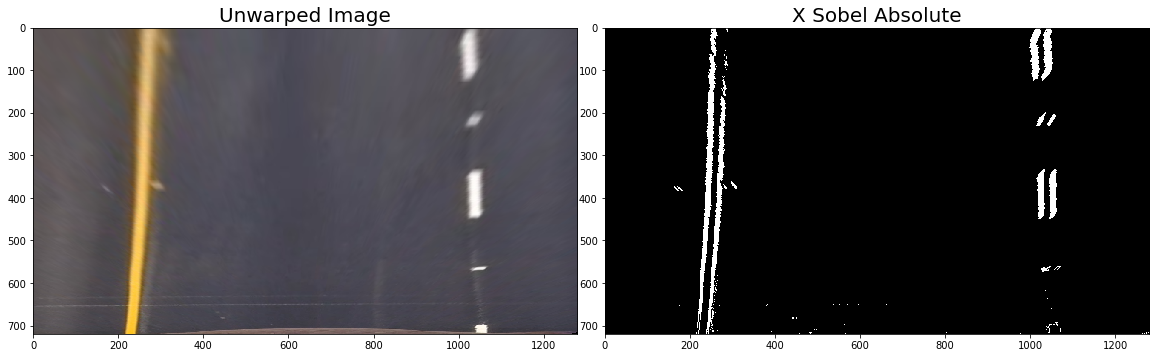

In [6]:
aImg_Sobel = abs_sobel_thresh(aImg_unwarp, orient='x', thresh_min=20, thresh_max=100)

displayResult(aImg_unwarp, aImg_Sobel, 'Unwarped Image', 'X Sobel Absolute', False  )

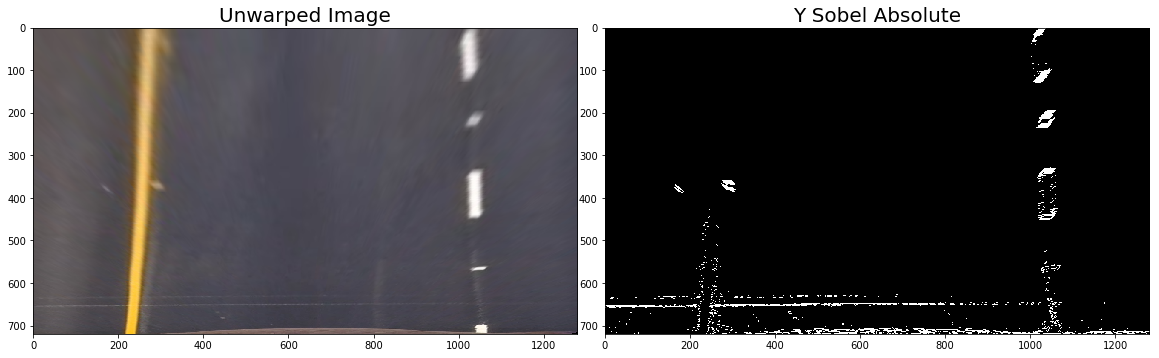

In [7]:
aImg_Sobel = abs_sobel_thresh(aImg_unwarp, orient='y', thresh_min=10, thresh_max=50)

displayResult(aImg_unwarp, aImg_Sobel, 'Unwarped Image', 'Y Sobel Absolute', False  )

### Magnitude of the Gradient

* Gradient magnitude is at the heart of Canny edge detection
    * Canny works well for picking up all edges.
    * we're interested only in edges of a particular orientation.
    * we will explore the direction, or orientation, of the gradient.
    
    
* The magnitude, or absolute value, of the gradient is just the square root of the squares of the individual x and y gradients.
    * The size of the region in the image over which you'll be taking the gradient. 
    * You can modify the kernel size for the Sobel operator to change the size of this region. 
        * Taking the gradient over larger regions can smooth over noisy intensity fluctuations on small scales. 
        * The default Sobel kernel size is 3, define a new function that takes kernel size as a parameter.
        * the kernel size should be an odd number.

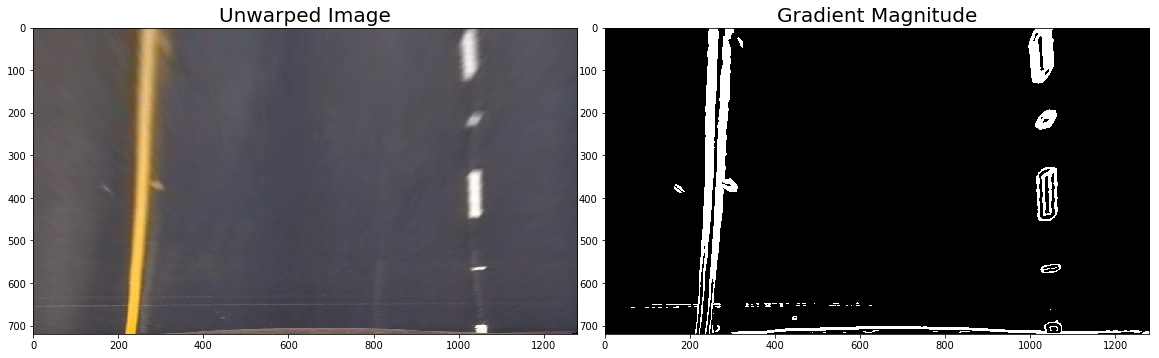

In [8]:
aImg_MagBinary = mag_thresh(aImg_unwarp, sobel_kernel=25, mag_thresh=(20, 100))

displayResult(aImg_unwarp, aImg_MagBinary, 'Unwarped Image', 'Gradient Magnitude', False  )

### Direction of the Gradient

* The direction of the gradient
    * the inverse tangent (arctangent) of the yy gradient divided by the xx gradient:
    * arctan{(sobel_y/sobel_x)}
    
* Each pixel of the resulting image contains a value for the angle of the gradient away from horizontal in units of radians
    (covering a range of −π/2 to π/2.) 
    * An orientation of 0 implies a vertical line
    * orientations of {+/-} π/2 imply horizontal lines

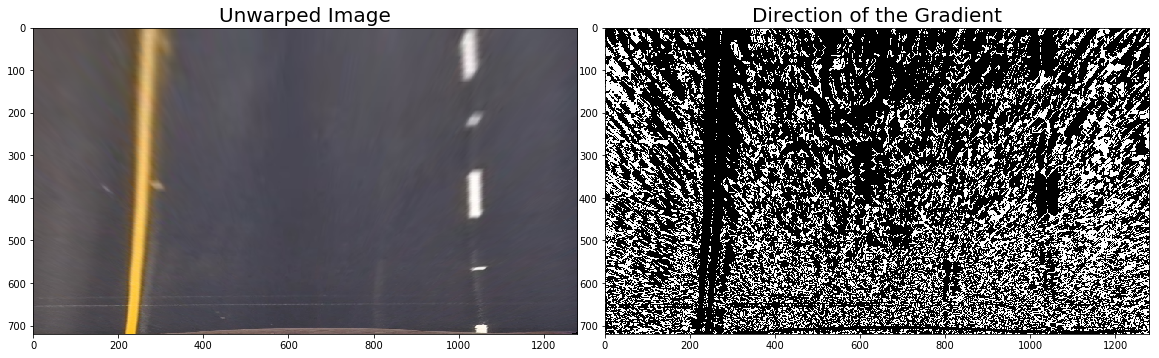

In [9]:
dir_binary = dir_threshold(aImg_unwarp, sobel_kernel=15, thresh=(0.7, 1.3))

displayResult(aImg_unwarp, dir_binary, 'Unwarped Image', 'Direction of the Gradient' , False )

### Magnitude & Direction of the Gradient

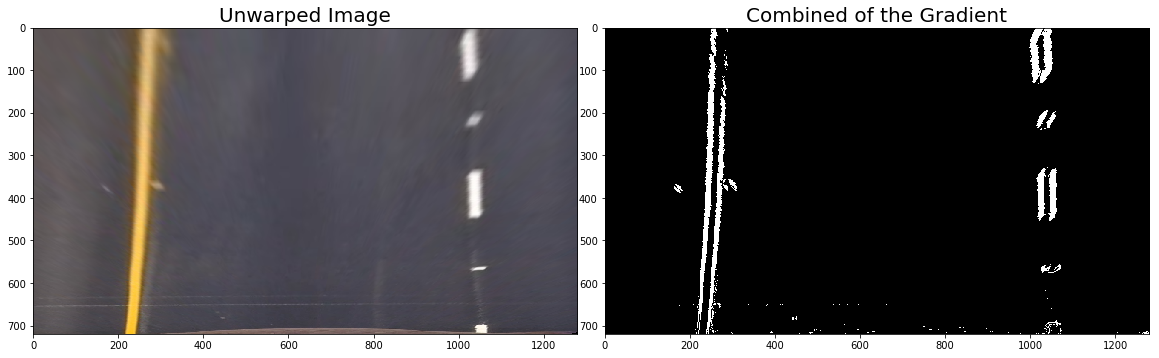

In [10]:
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(aImg_unwarp, orient='x', thresh_min=20, thresh_max=100)
#grady = abs_sobel_thresh(aImg_unwarp, orient='y', thresh_min=10, thresh_max=50)
mag_binary = mag_thresh(aImg_unwarp, sobel_kernel=25, mag_thresh=(20, 100))
dir_binary = dir_threshold(aImg_unwarp, sobel_kernel=15, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1

displayResult(aImg_unwarp, combined, 'Unwarped Image', 'Combined of the Gradient' , False )

## Color Spaces

### HLS and Color Thresholds

* A color space 
    * specific organization of colors
    * color spaces provide a way to categorize colors and represent them in digital images.

* Types of Color Space
    * RGB 
        * Red - Green - Blue color space.
        * matplotlib.image.imread() will give a RGB image.
    
    * BGR 
        * Blue - Green - Red color space
        * Using OpenCV cv2.imread() will give a BGR image.
        
    * HSV 
        * Hue, Saturation, and Value
    * HLS
        * Hue, Lightness, and Saturation
        
* Basic Color
    * Hue
        * the value that represents color independent of any change in brightness. 
        * if you imagine a basic red paint color, then add some white to it or some black to make that color lighter or darker?
            * the underlying color remains the same and the hue for all of these colors will be the same.
            
    * Lightness and Value 
        * different ways to measure the relative lightness or darkness of a color. 
        * For example, a dark red will have a similar hue but much lower value for lightness than a light red.
        
    * Saturation
        * saturation is a measurement of colorfulness. 
        * As colors get lighter and closer to white, they have a lower saturation value
        * whereas colors that are the most intense, like a bright primary color (imagine a bright red, blue, or yellow), have a high saturation value. 

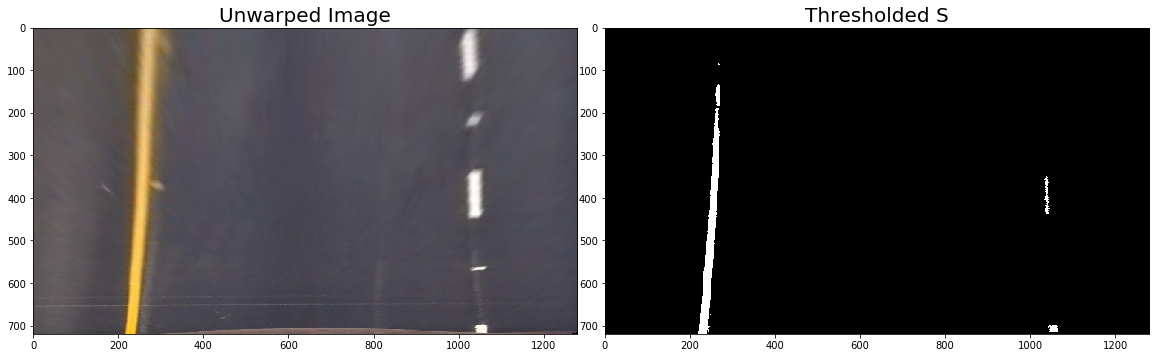

In [11]:
aImg_HLS = hls_select(aImg_unwarp, thresh=(170, 255))

displayResult(aImg_unwarp, aImg_HLS, 'Unwarped Image', 'Thresholded S' , False )

## Combine the Gradient and HLS Thresholds

In [12]:
# Edit this function to create your own pipeline.
def pipelineTest1(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    return color_binary

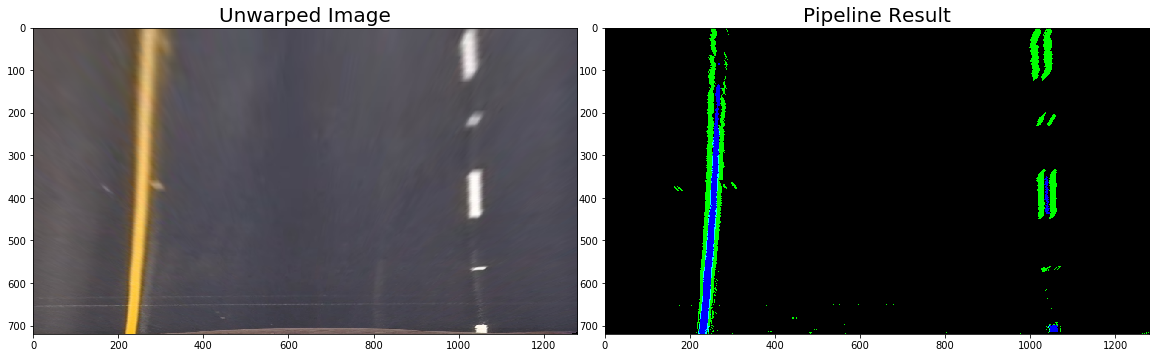

In [13]:
result = pipelineTest1(aImg_unwarp)

displayResult(aImg_unwarp, result, 'Unwarped Image', 'Pipeline Result' , False )

## Pipeline

In [14]:
# Edit this function to create your own pipeline.
def pipelineTest2(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    # unwarp the image
    undistort_Img = undistort(img, dist, mtx)
    unwarp_Img, M, Minv = unwarp(undistort_Img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(unwarp_Img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

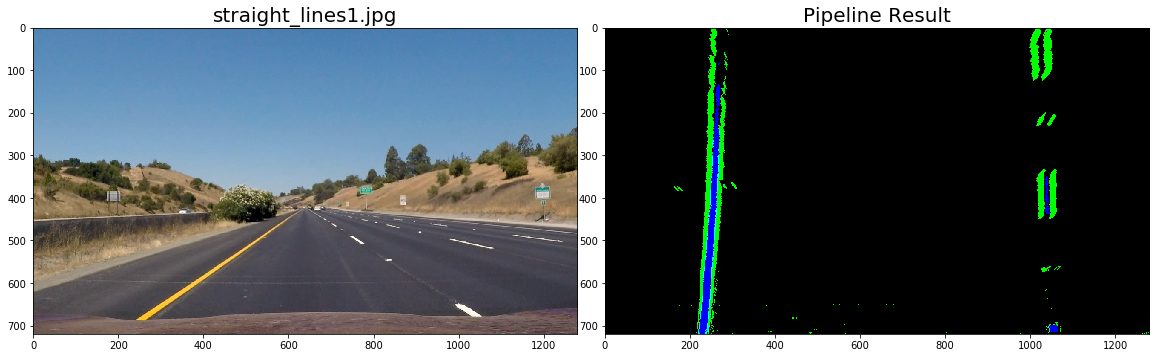

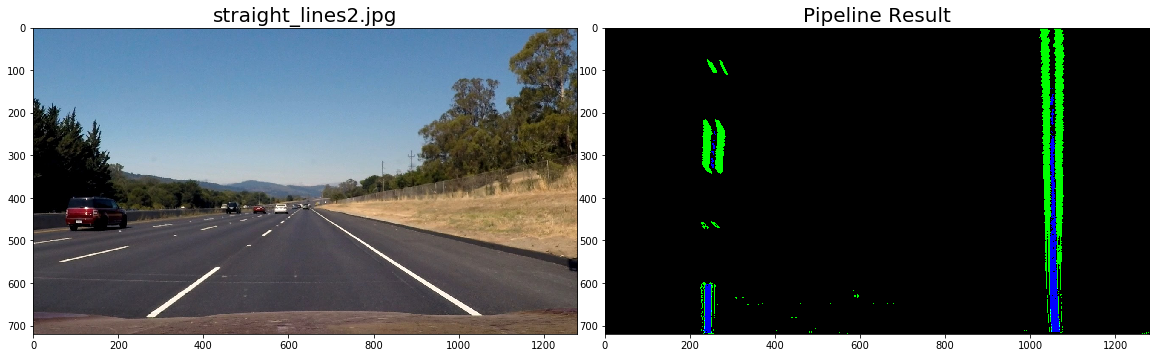

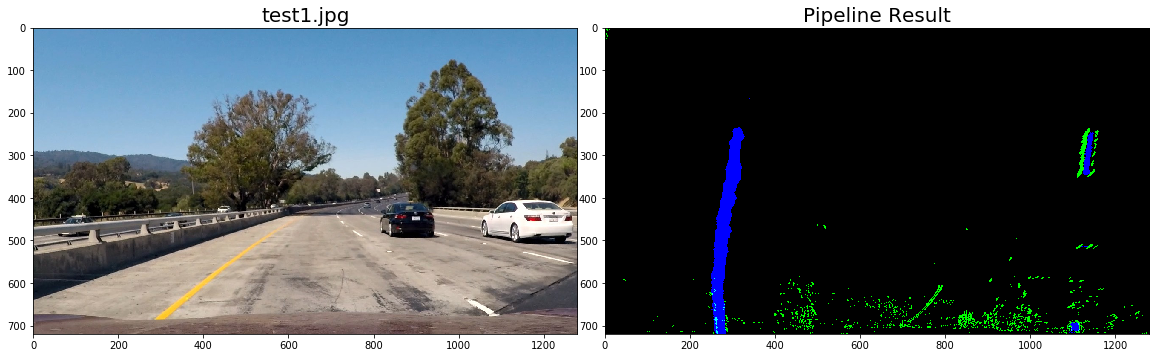

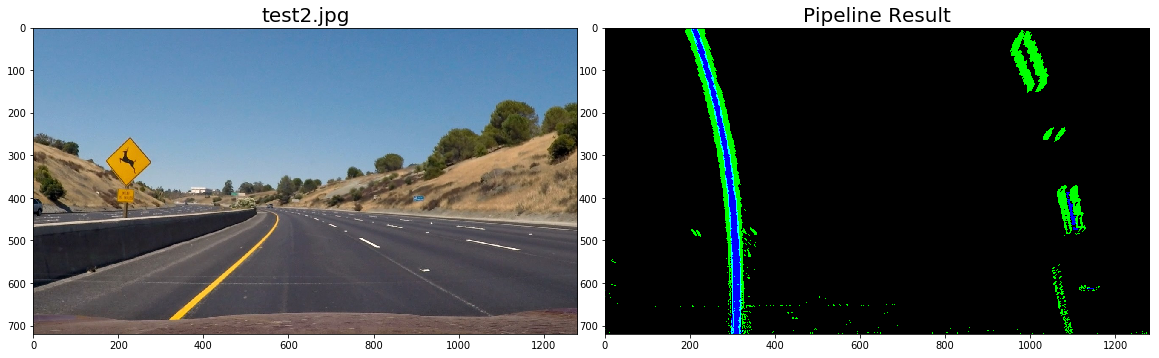

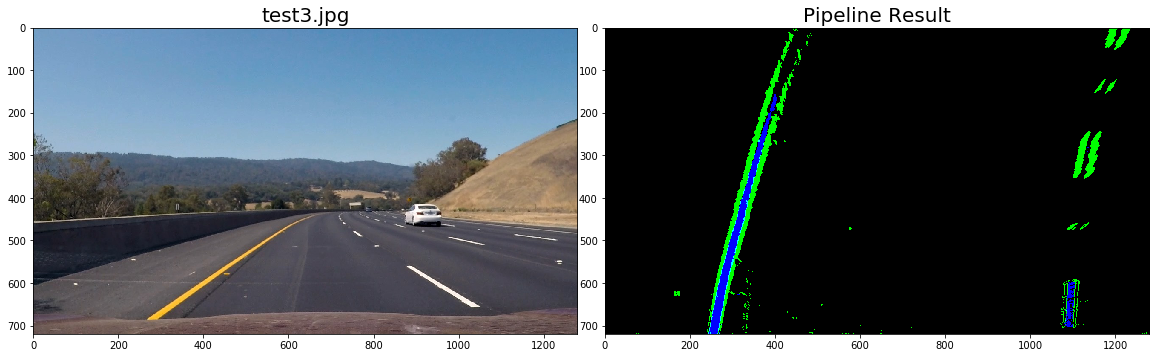

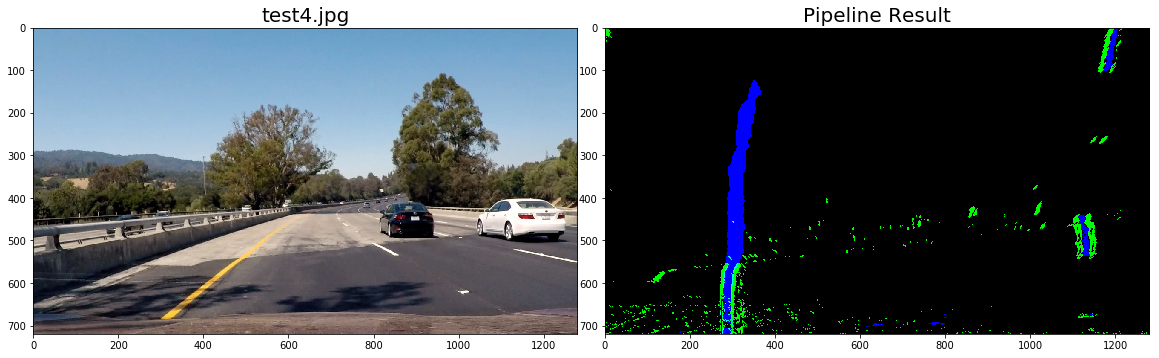

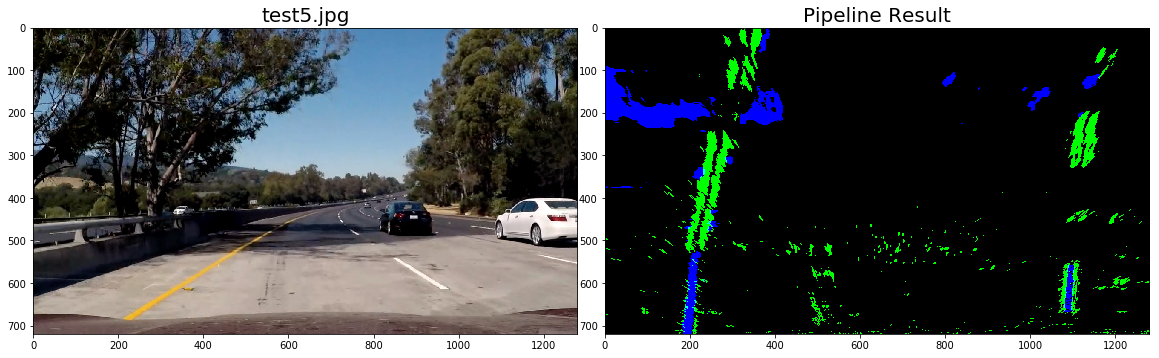

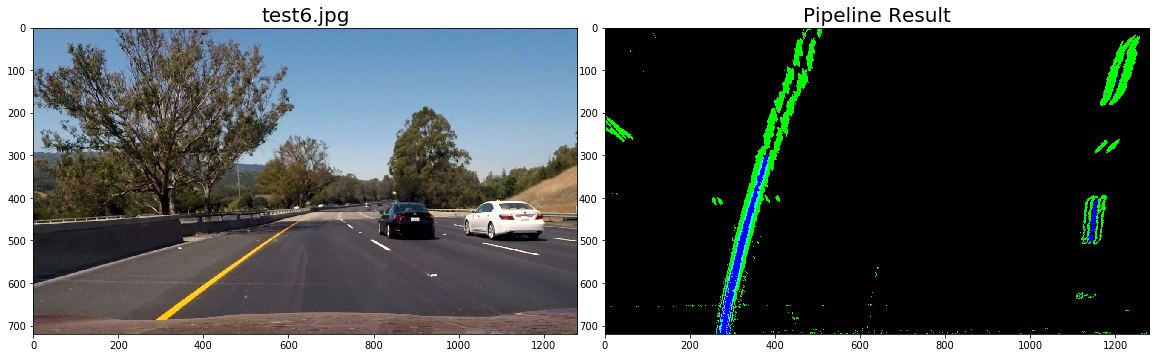

In [15]:
# Choose a test image 
images = glob.glob('./test_images/*.jpg')

for image in images:
    originalImg = cv2.imread(image)
    originalImg = cv2.cvtColor(originalImg, cv2.COLOR_BGR2RGB)
    img = np.copy(originalImg)
    
    result = pipelineTest2(img)
    
    displayResult(originalImg, result, os.path.basename(image), 'Pipeline Result' , False )

## Find Line

### Peaks in a Histogram

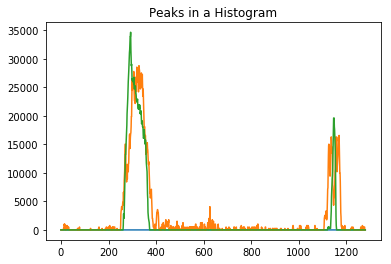

In [16]:
histogram = np.sum(result[result.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.title('Peaks in a Histogram')
print('')

### Sliding Windows

In [17]:
# Choose the number of sliding windows
nwindows = 9
    
# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

In [18]:
def sliding_windows( binary_warped ):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin    
    
        # Draw the windows on the visualization image    
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_lane_inds, right_lane_inds, left_fit, right_fit, out_img

In [19]:
def drew_windows( binary_warped, left_lane_inds, right_lane_inds, left_fit, right_fit, out_img ) :
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, left_fitx, right_fitx, ploty   


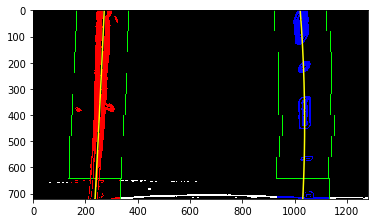

In [20]:
left_lane_inds, right_lane_inds, left_fit, right_fit, out_img = sliding_windows (aImg_MagBinary)
out_img, left_fitx, right_fitx, ploty = drew_windows( aImg_MagBinary, left_lane_inds, right_lane_inds, left_fit, right_fit, out_img )

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

print()

In [21]:
def get_Window_Margin(binary_warped, left_fit, right_fit  ) :
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty

In [22]:
def drew_Window_Margin(binary_warped, left_lane_inds, right_lane_inds, left_fitx, right_fitx ) :
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result 



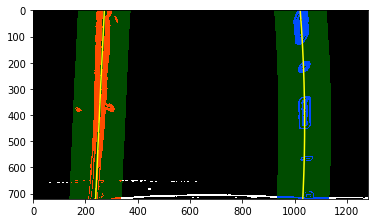

In [23]:
left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty = get_Window_Margin( aImg_MagBinary, left_fit , right_fit ) 
result = drew_Window_Margin( aImg_MagBinary, left_lane_inds, right_lane_inds, left_fitx, right_fitx ) 

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
print()

### Measuring Curvature

In [24]:
# Generate some fake data to represent lane-line pixels
yRange = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [25]:
def calculatePixelCurvature( left_fit, right_fit, ploty ) :
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Example values: 1926.74 1908.48
    return left_curverad, right_curverad


In [26]:
def calculateActualCurvature( left_fitx, right_fitx, ploty ) :

    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters
    return left_curverad, right_curverad
    # Example values: 632.1 m    626.2 m

In [27]:
left_curverad, right_curverad =  calculatePixelCurvature( left_fit, right_fit, yRange )

print('Left : {:.2f}, Right : {:.2f}'.format(left_curverad, right_curverad))

left_curverad, right_curverad = calculateActualCurvature( left_fitx , right_fitx, yRange ) 

print('Left : {:.2f}, Right : {:.2f}'.format(left_curverad, right_curverad))

Left : 74667.16, Right : 5678.27
Left : 30633.45, Right : 1858.25
